In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from init import download_data, plot_line, plot_hist, plot_box
from descriptive_analytics_fun import get_AdjC

import yfinance as yf


In [2]:
def compute_CCreturns(df, aggregation = "M", name=""):
    df_adj = df["Adj Close"]    # using only adj closes
    df_adj_op = df_adj.groupby(pd.Grouper(freq = aggregation))  # aggregation (default: monthly)
    df_adj = df_adj_op.mean()   # aggregate with avg
    df_returns = np.log(df_adj/df_adj.shift(1)) # calculating CC returns
    df_returns.name = name + " CC Return"
    
    # dropping NA values
    return df_returns.dropna()

In [3]:
# downloading data starting from 10 years ago (120 months)
stocks = ["AAPL", "NVDA", "KO", "UL", "BAC", "AXP"]
yf.pdr_override()

dataframes = download_data(stocks = stocks, start_stream = '2010-06-01')
ccrs = {} # continuous compounds returns
# using cc returns due to his stationary characteristic
for df in dataframes:
    ccrs[df] = compute_CCreturns(dataframes[df], name = df)
    ccrs[df] = ccrs[df].to_frame()
    ccrs[df].columns = ['Target']

[*********************100%%**********************]  1 of 1 completed
Done
[*********************100%%**********************]  1 of 1 completed
Done
[*********************100%%**********************]  1 of 1 completed
Done
[*********************100%%**********************]  1 of 1 completed
Done
[*********************100%%**********************]  1 of 1 completed
Done
[*********************100%%**********************]  1 of 1 completed
Done


The dataset has been divided into two segments: the first 110 months, which are utilized for training and testing purposes denoted as (n and m), while the last 10 months, referred to as (l), are specifically designated for forecasting. For the construction of the dataset, each record comprises `N + 1` columns: `[lag.1, lag.2, ..., lag.N, target]`. The initial `N` columns represent measurements from the preceding `N` days (or the chosen temporal window) before the target, assisting in the estimation of the target value (N-month average measurements). Typically, `N = 3`.

In [4]:
stock_id = "AAPL"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.085844,-0.014328,-0.024010,0.094308
2010-11-30,0.094308,0.085844,-0.014328,0.034790
2010-12-31,0.034790,0.094308,0.085844,0.031272
2011-01-31,0.031272,0.034790,0.094308,0.051216
2011-02-28,0.051216,0.031272,0.034790,0.037137
...,...,...,...,...
2019-07-31,0.010144,-0.044666,0.089805,0.061535
2019-08-31,0.061535,0.010144,-0.044666,0.001519
2019-09-30,0.001519,0.061535,0.010144,0.062681



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,0.111937,0.076332,0.062681,0.052561
2020-01-31,0.052561,0.111937,0.076332,0.120431
2020-02-29,0.120431,0.052561,0.111937,-0.000212
2020-03-31,-0.000212,0.120431,0.052561,-0.170114
2020-04-30,-0.170114,-0.000212,0.120431,0.037183
2020-05-31,0.037183,-0.170114,-0.000212,0.131361
2020-06-30,0.131361,0.037183,-0.170114,0.110000
2020-07-31,0.110000,0.131361,0.037183,0.100235
2020-08-31,0.100235,0.110000,0.131361,0.206391


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it

In [6]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)

# C: Controls the regularization strength in the SVR model.
# gamma: Defines the width of the radial basis function (RBF) kernel in the SVR model.
# epsilon: Specifies the margin of tolerance in SVR.

Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))


Best Model found:
	mse_svm: 0.0036465104424508767
	C: 1000.0
	gamma: 0.001
	epsilon: 0.001


In [7]:
svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

SVR(C=1000.0, epsilon=0.001, gamma=0.001)

Testing


array([ 0.02787615,  0.04112502,  0.02693366,  0.00938483, -0.0173593 ,
       -0.01013886, -0.0025355 ,  0.02891252,  0.02225832,  0.01154576,
        0.02458151,  0.03206167,  0.03088017,  0.00534479,  0.0560139 ,
        0.00694639,  0.01524492,  0.02030529,  0.0320359 ,  0.01115813,
        0.03108634,  0.00970504,  0.00067787, -0.01288857,  0.01671953,
       -0.0086085 ,  0.02484366,  0.01877938])

['./svm_models/svm_model_AAPL.pkl']

In [8]:
print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2019-12-31,0.052561,0.044629
2020-01-31,0.120431,0.030696
2020-02-29,-0.000212,0.050828
2020-03-31,-0.170114,0.015360
2020-04-30,0.037183,-0.022166
2020-05-31,0.131361,0.020475
2020-06-30,0.110000,0.030431
2020-07-31,0.100235,0.042048
2020-08-31,0.206391,0.047307


Mse between actual values and predicted ones: 0.010421855594343329

Sum of actual values (returns): 		 0.5694469766849128
Sum of predicted values (returns): 	 0.332077152711577


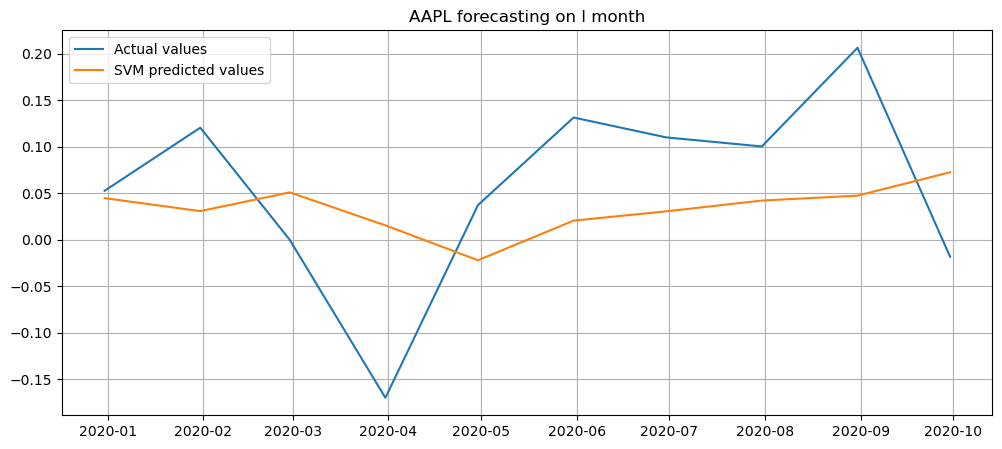

In [9]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()

In [10]:
stock_id = "AXP"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10
                                     )

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it


dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,-0.004490,-0.018176,0.053312,-0.052394
2010-11-30,-0.052394,-0.004490,-0.018176,0.081691
2010-12-31,0.081691,-0.052394,-0.004490,0.035392
2011-01-31,0.035392,0.081691,-0.052394,0.016300
2011-02-28,0.016300,0.035392,0.081691,0.002193
...,...,...,...,...
2019-07-31,0.031993,0.049772,0.023408,0.040104
2019-08-31,0.040104,0.031993,0.049772,-0.033967
2019-09-30,-0.033967,0.040104,0.031993,-0.031181



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,0.032003,-0.015728,-0.031181,0.019905
2020-01-31,0.019905,0.032003,-0.015728,0.057201
2020-02-29,0.057201,0.019905,0.032003,0.003516
2020-03-31,0.003516,0.057201,0.019905,-0.337853
2020-04-30,-0.337853,0.003516,0.057201,-0.075495
2020-05-31,-0.075495,-0.337853,0.003516,0.035784
2020-06-30,0.035784,-0.075495,-0.337853,0.141077
2020-07-31,0.141077,0.035784,-0.075495,-0.066868
2020-08-31,-0.066868,0.141077,0.035784,0.039466


In [11]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))

svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')


Best Model found:
	mse_svm: 0.0018556722476572955
	C: 100.0
	gamma: 0.001
	epsilon: 0.001


SVR(C=100.0, epsilon=0.001, gamma=0.001)

Testing


array([0.01271354, 0.018213  , 0.01162323, 0.01454614, 0.00272238,
       0.01117729, 0.01822807, 0.02460415, 0.01860965, 0.00261937,
       0.01250993, 0.01449995, 0.01202159, 0.02068686, 0.01852849,
       0.01501085, 0.01830759, 0.01283092, 0.01002246, 0.01812284,
       0.01782461, 0.01606289, 0.00620634, 0.01074304, 0.02035128,
       0.01411824, 0.00445284, 0.01260369])

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2019-12-31,0.019905,0.020927
2020-01-31,0.057201,0.017566
2020-02-29,0.003516,0.019504
2020-03-31,-0.337853,0.013095
2020-04-30,-0.075495,-0.027391
2020-05-31,0.035784,0.013875
2020-06-30,0.141077,0.039879
2020-07-31,-0.066868,0.034890
2020-08-31,0.039466,0.002117


Mse between actual values and predicted ones: 0.015014289264454509

Sum of actual values (returns): 		 -0.15080096066902732
Sum of predicted values (returns): 	 0.14779520317579348


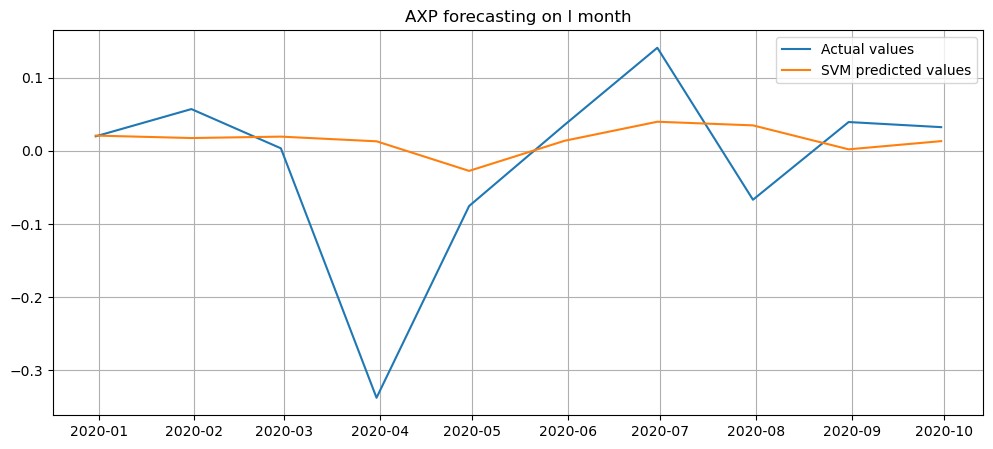

In [12]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()

In [13]:
stock_id = "BAC"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it


dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.014454,-0.078309,-0.071728,-0.081585
2010-11-30,-0.081585,0.014454,-0.078309,-0.052042
2010-12-31,-0.052042,-0.081585,0.014454,0.067183
2011-01-31,0.067183,-0.052042,-0.081585,0.129419
2011-02-28,0.129419,0.067183,-0.052042,0.013305
...,...,...,...,...
2019-07-31,-0.023752,-0.028248,0.039080,0.058974
2019-08-31,0.058974,-0.023752,-0.028248,-0.077445
2019-09-30,-0.077445,0.058974,-0.023752,0.064128



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,0.098656,0.025577,0.064128,0.047478
2020-01-31,0.047478,0.098656,0.025577,-0.001262
2020-02-29,-0.001262,0.047478,0.098656,-0.026835
2020-03-31,-0.026835,-0.001262,0.047478,-0.374818
2020-04-30,-0.374818,-0.026835,-0.001262,-0.013567
2020-05-31,-0.013567,-0.374818,-0.026835,0.018348
2020-06-30,0.018348,-0.013567,-0.374818,0.104527
2020-07-31,0.104527,0.018348,-0.013567,-0.052524
2020-08-31,-0.052524,0.104527,0.018348,0.073563


In [14]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))

svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')


Best Model found:
	mse_svm: 0.005233850675089931
	C: 1000.0
	gamma: 0.01
	epsilon: 0.01


SVR(C=1000.0, epsilon=0.01, gamma=0.01)

Testing


array([ 0.01724095, -0.01393235,  0.03749717,  0.01811598, -0.02809026,
        0.0227239 ,  0.02707817,  0.01656768,  0.00484976, -0.07934566,
       -0.0028881 ,  0.01800729,  0.00729006,  0.00020038,  0.05999738,
        0.01524846,  0.02151423,  0.01592999,  0.03669878,  0.02912176,
       -0.0221517 ,  0.01374063, -0.03034735,  0.0301938 , -0.01561183,
        0.0058133 ,  0.01252721,  0.0241306 ])

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2019-12-31,0.047478,0.043021
2020-01-31,-0.001262,0.021227
2020-02-29,-0.026835,0.017648
2020-03-31,-0.374818,0.006502
2020-04-30,-0.013567,-0.094268
2020-05-31,0.018348,0.015630
2020-06-30,0.104527,-0.029212
2020-07-31,-0.052524,0.036377
2020-08-31,0.073563,-0.008094


Mse between actual values and predicted ones: 0.01922530546106869

Sum of actual values (returns): 		 -0.2547800589265271
Sum of predicted values (returns): 	 0.052396712466114326


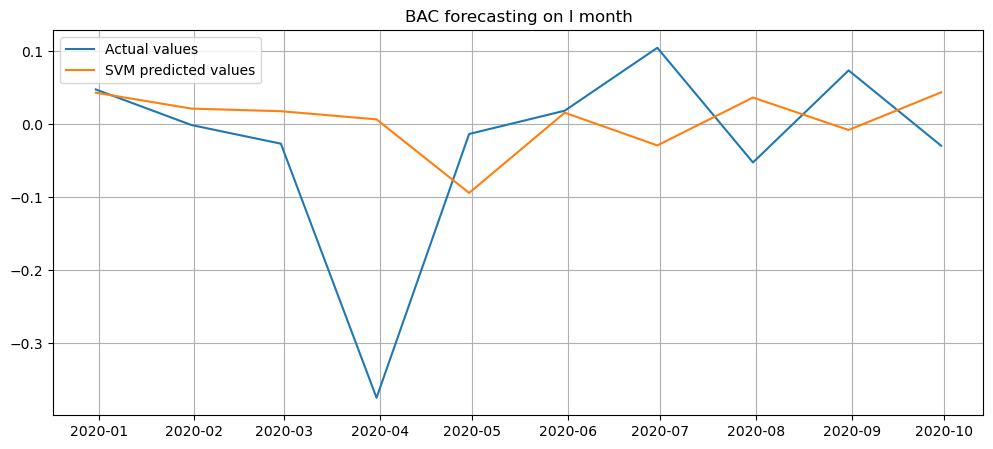

In [15]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()

In [16]:
stock_id = "KO"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it


dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.040614,0.054401,0.028712,0.040657
2010-11-30,0.040657,0.040614,0.054401,0.044715
2010-12-31,0.044715,0.040657,0.040614,0.037447
2011-01-31,0.037447,0.044715,0.040657,-0.028399
2011-02-28,-0.028399,0.037447,0.044715,0.004231
...,...,...,...,...
2019-07-31,0.052389,0.032327,0.033693,0.028322
2019-08-31,0.028322,0.052389,0.032327,0.023768
2019-09-30,0.023768,0.028322,0.052389,0.019716



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,-0.018489,-0.009177,0.019716,0.036124
2020-01-31,0.036124,-0.018489,-0.009177,0.036081
2020-02-29,0.036081,0.036124,-0.018489,0.038269
2020-03-31,0.038269,0.036081,0.036124,-0.202736
2020-04-30,-0.202736,0.038269,0.036081,-0.024159
2020-05-31,-0.024159,-0.202736,0.038269,-0.023748
2020-06-30,-0.023748,-0.024159,-0.202736,0.033059
2020-07-31,0.033059,-0.023748,-0.024159,0.003121
2020-08-31,0.003121,0.033059,-0.023748,0.030477


In [17]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))

svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')


Best Model found:
	mse_svm: 0.0006490553186139252
	C: 0.001
	gamma: 1000.0
	epsilon: 0.001


SVR(C=0.001, epsilon=0.001, gamma=1000.0)

Testing


array([0.00721912, 0.00886686, 0.00647134, 0.00601625, 0.00467658,
       0.00595975, 0.00798057, 0.0061944 , 0.00583306, 0.00573846,
       0.00687526, 0.00703323, 0.00746037, 0.00746731, 0.00759164,
       0.00611353, 0.005607  , 0.00603407, 0.00629436, 0.00664547,
       0.00799995, 0.00598204, 0.00878177, 0.00535899, 0.00818285,
       0.00832501, 0.00526697, 0.00509127])

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2019-12-31,0.036124,0.005856
2020-01-31,0.036081,0.008045
2020-02-29,0.038269,0.010080
2020-03-31,-0.202736,0.008083
2020-04-30,-0.024159,0.006992
2020-05-31,-0.023748,0.006992
2020-06-30,0.033059,0.006992
2020-07-31,0.003121,0.007301
2020-08-31,0.030477,0.007033


Mse between actual values and predicted ones: 0.005153667007397251

Sum of actual values (returns): 		 -0.027923038516878773
Sum of predicted values (returns): 	 0.07510770358010131


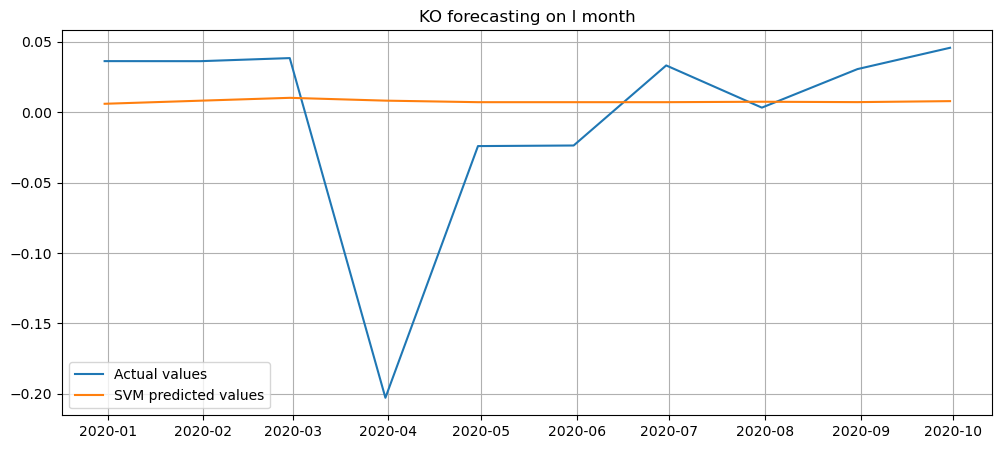

In [18]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()

In [19]:
stock_id = "NVDA"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it


dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.132023,-0.087634,-0.115589,0.049400
2010-11-30,0.049400,0.132023,-0.087634,0.135860
2010-12-31,0.135860,0.049400,0.132023,0.124481
2011-01-31,0.124481,0.135860,0.049400,0.387968
2011-02-28,0.387968,0.124481,0.135860,0.092854
...,...,...,...,...
2019-07-31,-0.065435,-0.156861,0.111926,0.115436
2019-08-31,0.115436,-0.065435,-0.156861,-0.046202
2019-09-30,-0.046202,0.115436,-0.065435,0.100950



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,0.099627,0.072911,0.100950,0.065134
2020-01-31,0.065134,0.099627,0.072911,0.085942
2020-02-29,0.085942,0.065134,0.099627,0.101437
2020-03-31,0.101437,0.085942,0.065134,-0.105999
2020-04-30,-0.105999,0.101437,0.085942,0.128672
2020-05-31,0.128672,-0.105999,0.101437,0.167032
2020-06-30,0.167032,0.128672,-0.105999,0.108242
2020-07-31,0.108242,0.167032,0.128672,0.115042
2020-08-31,0.115042,0.108242,0.167032,0.157841


In [20]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))

svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')

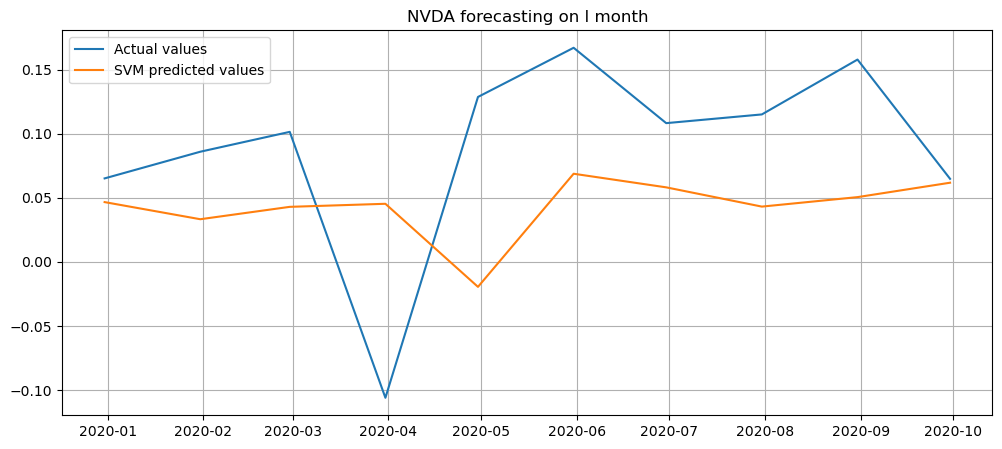

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()

In [ ]:
stock_id = "UL"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it


dataset with lag columns: 

110 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.029934,-0.046292,0.034141,0.038534
2010-11-30,0.038534,0.029934,-0.046292,0.030244
2010-12-31,0.030244,0.038534,0.029934,0.022698
2011-01-31,0.022698,0.030244,0.038534,-0.008688
2011-02-28,-0.008688,0.022698,0.030244,-0.015003
...,...,...,...,...
2019-07-31,0.026498,0.049517,0.041540,0.002780
2019-08-31,0.002780,0.026498,0.049517,-0.022152
2019-09-30,-0.022152,0.002780,0.026498,0.017163



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2019-12-31,0.003687,-0.036371,0.017163,-0.013109
2020-01-31,-0.013109,0.003687,-0.036371,-0.017225
2020-02-29,-0.017225,-0.013109,0.003687,0.031768
2020-03-31,0.031768,-0.017225,-0.013109,-0.138449
2020-04-30,-0.138449,0.031768,-0.017225,0.008231
2020-05-31,0.008231,-0.138449,0.031768,0.002004
2020-06-30,0.002004,0.008231,-0.138449,0.086126
2020-07-31,0.086126,0.002004,0.008231,0.016871
2020-08-31,0.016871,0.086126,0.002004,0.061744


In [ ]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))

svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')


Best Model found:
	mse_svm: 0.0010275989580154432
	C: 0.01
	gamma: 100.0
	epsilon: 0.0001


SVR(C=0.01, epsilon=0.0001, gamma=100.0)

Testing


array([0.02119406, 0.01392992, 0.01162611, 0.01224629, 0.00779696,
       0.0104195 , 0.01588093, 0.01393923, 0.00917213, 0.01168256,
       0.00555748, 0.01294708, 0.01276359, 0.01304033, 0.00937021,
       0.01383777, 0.01055538, 0.01436729, 0.01137494, 0.01184984,
       0.00866261, 0.01143795, 0.01180826, 0.0141468 , 0.01466476,
       0.0161374 , 0.01004225, 0.00711328])

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2019-12-31,-0.013109,0.012182
2020-01-31,-0.017225,0.003401
2020-02-29,0.031768,0.009733
2020-03-31,-0.138449,0.011401
2020-04-30,0.008231,0.008881
2020-05-31,0.002004,0.009832
2020-06-30,0.086126,0.004017
2020-07-31,0.016871,0.020948
2020-08-31,0.061744,0.007781


Mse between actual values and predicted ones: 0.003373785686839883

Sum of actual values (returns): 		 0.0541947151724
Sum of predicted values (returns): 	 0.10436115130885759


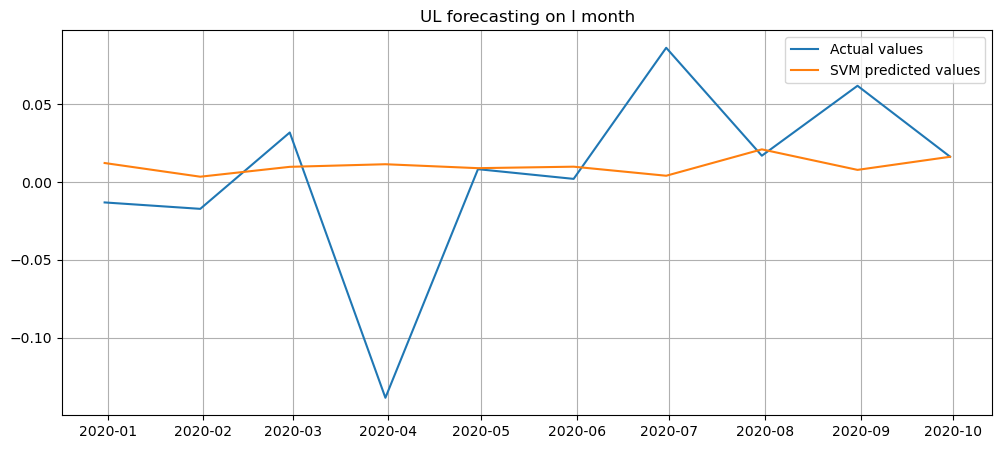

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l month')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()